In [1]:
import os
import sys
from os.path import join, abspath
import argparse
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import OrdinalEncoder
from sklearn.calibration import CalibratedClassifierCV
from scipy.sparse import hstack

import glob
import numpy as np

import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import roc_auc_score
import seaborn as sns

from collections import Counter

os.chdir('C:/Users/hwallace/python/sds_utils/shared/src')
sys.path.append(abspath('../..'))
from shared.src.data_access.external_db_connections import get_snowflake_database_connection, get_database_connection
from shared.src.config.analysis_config import AnalysisConfig

from shared.src.table_objects.snowflake_schemas.model import TGLACCOUNTNORMALIZATIONTRAINER

import requests
import json
import time

## Data Prep and Exploration

In [2]:
path = f"C:/Users/hwallace/glaccount/results"

In [3]:
all_files = glob.glob(os.path.join(path, '*.xlsx'))

In [4]:
all_files

['C:/Users/hwallace/glaccount/results\\1259 GL Account Final.xlsx',
 'C:/Users/hwallace/glaccount/results\\2022.06.14 gl_accounts existing clients.xlsx',
 'C:/Users/hwallace/glaccount/results\\GL New Accounts 10.13.22.xlsx',
 'C:/Users/hwallace/glaccount/results\\GL New Accounts 11.4.22.xlsx',
 'C:/Users/hwallace/glaccount/results\\GL New Accounts 8.11.22.xlsx',
 'C:/Users/hwallace/glaccount/results\\GL New Accounts 9.14.22.xlsx',
 'C:/Users/hwallace/glaccount/results\\GL New Clients 10.24.22.xlsx',
 'C:/Users/hwallace/glaccount/results\\GL New Clients 10.4.22.xlsx',
 'C:/Users/hwallace/glaccount/results\\GL New Clients 5.12.22.xlsx',
 'C:/Users/hwallace/glaccount/results\\GL New Clients 6.1.22.xlsx',
 'C:/Users/hwallace/glaccount/results\\gl_accounts_202206 ji edits.xlsx',
 'C:/Users/hwallace/glaccount/results\\gl_accounts_2734_2957 _8.1.22.xlsx',
 'C:/Users/hwallace/glaccount/results\\gl_accounts_3175_8.1.22.xlsx',
 'C:/Users/hwallace/glaccount/results\\gl_accounts_7.29.22.xlsx',
 'C

In [5]:
len(all_files)

21

In [6]:
dd = {}
d = {}
for i, file in enumerate(all_files):
    dd[i] = pd.read_excel(file, engine="openpyxl", sheet_name=None)
    d[i] =  pd.concat(dd[i].values(), ignore_index=True)
    d[i] = d[i].rename({"Jen's Review": 'Review'}, axis=1)
    d[i].loc[d[i]['LineItem'] == d[i]['Review'], 'Review'] = np.NaN
    d[i]['file'] = file

In [7]:
d.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [8]:
l = []
for i in range(len(d)):
    l = l + list(d[i].columns)

In [9]:
Counter(l)

Counter({'OrgPin': 21,
         'AccountID': 21,
         'AccountCode': 21,
         'Description': 21,
         'GLRollup': 21,
         'GLDollars': 21,
         'LineItem': 21,
         'Review': 21,
         'SPAccountRollupCategory': 21,
         'SPAccountRollupName': 21,
         'OBDollarsFinancialReporting': 21,
         'DSSAccountRollup1Name': 21,
         'Category': 21,
         'Section': 21,
         'Statement': 21,
         'IsDollarF': 13,
         'IsStat': 13,
         'file': 21,
         'OrgAccntID': 1,
         'OBDollarsFinancialReportingCategory': 1})

In [10]:
## 10.24 has one org with nothing
## 10.4 has one org with nothing 1259
## 5.05 has nothing in any of the orgs
## 7.8 and ji edits both have the same number of rows (?)
## ji edits seems to be correct

In [11]:
total = 0
dupes = 0
col = "Review"
for i in range(len(d)):
    print(f'file # {i}')
    print(f'file {all_files[i]}')
    print(f'length: {len(d[i])}')
    total += len(d[i])
    print(f'review nulls: {d[i][col].isna().sum()/len(d[i])}')
    cnts = d[i].groupby(['OrgPin', 'AccountID']).size().rename('cnt').reset_index()
    mults = cnts[cnts.cnt > 1]
    print(f'number of dupes {len(mults)}')
    print('')

    
print(f'total: {total}')
print(f'total sum of dupes within each file: {dupes}')

file # 0
file C:/Users/hwallace/glaccount/results\1259 GL Account Final.xlsx
length: 2278
review nulls: 0.43239683933274803
number of dupes 0

file # 1
file C:/Users/hwallace/glaccount/results\2022.06.14 gl_accounts existing clients.xlsx
length: 955
review nulls: 0.5884816753926702
number of dupes 0

file # 2
file C:/Users/hwallace/glaccount/results\GL New Accounts 10.13.22.xlsx
length: 688
review nulls: 0.5973837209302325
number of dupes 0

file # 3
file C:/Users/hwallace/glaccount/results\GL New Accounts 11.4.22.xlsx
length: 394
review nulls: 0.631979695431472
number of dupes 0

file # 4
file C:/Users/hwallace/glaccount/results\GL New Accounts 8.11.22.xlsx
length: 1711
review nulls: 0.33489187609585036
number of dupes 0

file # 5
file C:/Users/hwallace/glaccount/results\GL New Accounts 9.14.22.xlsx
length: 1517
review nulls: 0.26697429136453527
number of dupes 0

file # 6
file C:/Users/hwallace/glaccount/results\GL New Clients 10.24.22.xlsx
length: 292
review nulls: 0.705479452054794

In [12]:
df = pd.concat(d.values(), ignore_index = True)
df['OrgPin'] = df['OrgPin'].astype(str)
df.columns = [x.lower() for x in df.columns]

In [13]:
df.head()

,orgpin,accountid,accountcode,description,glrollup,gldollars,lineitem,review,spaccountrollupcategory,spaccountrollupname,obdollarsfinancialreporting,dssaccountrollup1name,category,section,statement,isdollarf,isstat,file,orgaccntid,obdollarsfinancialreportingcategory
0,1259,3965,41000-0000,ACCTS EST UNCOLL MISC -IP,HOSPITAL - IP,2.872130e+08,Revenue - Inpatient,Bad Debt,Deductions - Bad Debt,Bad Debt,IS - REVENUE DEDUCTIONS: - Bad Debt,Not Specified,Revenue - Patient - Gross,Revenue,Income Statement,1.0,0.0,C:/Users/hwallace/glaccount/results\1259 GL Ac...,NaN,NaN
1,1259,5694,41005-0000,ACCTS EST UNCOLL MISC -OP,HOSPITAL - OP,1.834493e+08,Revenue - Outpatient,Bad Debt,Deductions - Bad Debt,Bad Debt,IS - REVENUE DEDUCTIONS: - Bad Debt,Not Specified,Revenue - Patient - Gross,Revenue,Income Statement,1.0,0.0,C:/Users/hwallace/glaccount/results\1259 GL Ac...,NaN,NaN
2,1259,5506,41011-0000,BAD DEBT RECOVERIES AGENCY -IP,HOSPITAL - IP,-1.723962e+07,Bad Debt,NaN,Deductions - Bad Debt,Bad Debt,IS - REVENUE DEDUCTIONS: - Bad Debt,Not Specified,Revenue Deduction,Revenue,Income Statement,1.0,0.0,C:/Users/hwallace/glaccount/results\1259 GL Ac...,NaN,NaN
3,1259,4284,41014-0000,BAD DEBT RECOVERIES HOSP -OP,HOSPITAL - OP,-5.429000e+01,Bad Debt,NaN,Deductions - Bad Debt,Bad Debt,IS - REVENUE DEDUCTIONS: - Bad Debt,Not Specified,Revenue Deduction,Revenue,Income Statement,1.0,0.0,C:/Users/hwallace/glaccount/results\1259 GL Ac...,NaN,NaN
4,1259,5172,41012-0000,BAD DEBT RECOVERIES HOSP -IP,HOSPITAL - IP,-8.152721e+06,Bad Debt,NaN,Deductions - Bad Debt,Bad Debt,IS - REVENUE DEDUCTIONS: - Bad Debt,Not Specified,Revenue Deduction,Revenue,Income Statement,1.0,0.0,C:/Users/hwallace/glaccount/results\1259 GL Ac...,NaN,NaN


### SEND TO SNOWFLAKE TO ANALYSE REPEATS

### END ANALYSIS OF REPEATS

#### After checking for duplicates, the conclusion was that workbooks 7.7.22 and 7.8.22 are both duplicates of other sheets and are outdated. Additionally, 5.05.22 and 1259 GL Review have no corrections in them and its row corrections are found in other sheets.

### Workbook 5.2.22 has duplicates that are also in 5.11.22, and the 5.2.22 rows should be deleted, that happens below

In [14]:
cnts = df.groupby(['orgpin', 'accountid']).size().rename('cnt').reset_index()
mults = cnts[cnts.cnt > 1]
len(mults)

2136

In [15]:
df_m = df.merge(mults, on=['orgpin', 'accountid'])

In [16]:
df_m.groupby('file').size()

file
C:/Users/hwallace/glaccount/results\2022.06.14 gl_accounts existing clients.xlsx      51
C:/Users/hwallace/glaccount/results\GL New Accounts 10.13.22.xlsx                      1
C:/Users/hwallace/glaccount/results\GL New Accounts 11.4.22.xlsx                       1
C:/Users/hwallace/glaccount/results\GL New Accounts 8.11.22.xlsx                       6
C:/Users/hwallace/glaccount/results\GL New Accounts 9.14.22.xlsx                       9
C:/Users/hwallace/glaccount/results\GL New Clients 10.4.22.xlsx                        1
C:/Users/hwallace/glaccount/results\GL New Clients 6.1.22.xlsx                         1
C:/Users/hwallace/glaccount/results\St Francis post conversion GL 9.8.22.xlsx         14
C:/Users/hwallace/glaccount/results\VCU GL 7.28.22.xlsx                               56
C:/Users/hwallace/glaccount/results\gl_accounts_202206 ji edits.xlsx                  22
C:/Users/hwallace/glaccount/results\gl_accounts_existing 5.11.22.xlsx               2078
C:/Users/hwallac

In [17]:
df_mj = df_m.merge(df_m, on=['orgpin', 'accountid'])

In [18]:
df_mj = df_mj.loc[df_mj.file_x != df_mj.file_y]

In [19]:
df_mj.groupby(['file_x','file_y']).size()

file_x                                                                            file_y                                                                          
C:/Users/hwallace/glaccount/results\2022.06.14 gl_accounts existing clients.xlsx  C:/Users/hwallace/glaccount/results\St Francis post conversion GL 9.8.22.xlsx         12
                                                                                  C:/Users/hwallace/glaccount/results\VCU GL 7.28.22.xlsx                               23
                                                                                  C:/Users/hwallace/glaccount/results\gl_accounts_202206 ji edits.xlsx                  15
                                                                                  C:/Users/hwallace/glaccount/results\gl_accounts_existing 5.11.22.xlsx                 12
C:/Users/hwallace/glaccount/results\GL New Accounts 10.13.22.xlsx                 C:/Users/hwallace/glaccount/results\GL New Accounts 11.4.22.xlsx       

In [20]:
# df_mj = df_mj.fillna('none')
# df_mj.loc[df_mj.review_x != df_mj.review_y, ['orgpin', 'accountid', 'lineitem_x', 'lineitem_y', 'review_x', 'review_y']]

In [21]:
df_m52 = df_m.loc[df_m.file.str.contains('5.2.22'), ['orgpin','accountid','file','cnt']]

In [22]:
df = df.merge(df_m52, how='left')

In [23]:
df.shape

(76825, 21)

In [24]:
df['cnt'] = df['cnt'].fillna(1.0)

In [25]:
df.groupby(['file', 'cnt']).size()

file                                                                              cnt
C:/Users/hwallace/glaccount/results\1259 GL Account Final.xlsx                    1.0     2278
C:/Users/hwallace/glaccount/results\2022.06.14 gl_accounts existing clients.xlsx  1.0      955
C:/Users/hwallace/glaccount/results\GL New Accounts 10.13.22.xlsx                 1.0      688
C:/Users/hwallace/glaccount/results\GL New Accounts 11.4.22.xlsx                  1.0      394
C:/Users/hwallace/glaccount/results\GL New Accounts 8.11.22.xlsx                  1.0     1711
C:/Users/hwallace/glaccount/results\GL New Accounts 9.14.22.xlsx                  1.0     1517
C:/Users/hwallace/glaccount/results\GL New Clients 10.24.22.xlsx                  1.0      292
C:/Users/hwallace/glaccount/results\GL New Clients 10.4.22.xlsx                   1.0     2816
C:/Users/hwallace/glaccount/results\GL New Clients 5.12.22.xlsx                   1.0     2947
C:/Users/hwallace/glaccount/results\GL New Clients 6.1.22.x

In [26]:
df = df.loc[df.cnt == 1]

In [27]:
df.shape

(74781, 21)

### Example from Kendall of sending observations to be scored by sagemaker

In [200]:
# t=TGLACCOUNTNORMALIZATIONTRAINER
# print(t.__table__.name)
# dtreq=pd.read_sql(t.__table__.select().limit(10000), con=get_snowflake_database_connection())
# print(dtreq.shape)
# print(dtreq.columns)
# cols=['orgpin', 'accountid', 'gldescription', 'glrollup']
# s1=dtreq[cols][5000:5003].copy()

In [96]:
# # FOR LOCAL
# # url1='http://localhost:5000/glaccount'
# # FOR SDSUTILS
# # url1='https://sdsutils.prod.stratanetwork.net/glaccount'
# # FOR AWS
# url1='https://czhu46jwq8.execute-api.us-east-1.amazonaws.com/test/sdt-sds-glnormalization'
# s1['accountid']=s1['accountid'].astype(int)
# awscols=['OrgPin', 'AccountID', 'Description', 'GLRollup']
# s1.columns=awscols
# obj1=s1.to_json(orient='records')

In [ ]:
# x1=requests.post(url1, data=obj1)
# x1=json.loads(x1.text)['body']['result']

### Setting up to send our spreadsheet observations through sagemaker to get confidence scores

In [28]:
def gl_req(data, url1='https://czhu46jwq8.execute-api.us-east-1.amazonaws.com/test/sdt-sds-glnormalization'):
    df_json = data.to_json(orient='records')
    result = requests.post(url1, data=df_json)
    result = json.loads(result.text)['body']['result']
    resultdf = pd.DataFrame.from_records(result)
    return resultdf

In [39]:
df_test = df[['orgpin', 'accountid', 'description', 'glrollup']].copy()
awscols=['OrgPin', 'AccountID', 'Description', 'GLRollup']
df_test.columns = awscols
df_test = df_test.fillna('')

In [40]:
df_test['OrgPin'] = df_test['OrgPin'].astype(str)
df_test['AccountID'] = df_test['AccountID'].astype(int)
df_test['Description'] = df_test['Description'].astype(str)
df_test['GLRollup'] = df_test['GLRollup'].astype(str)
df_test = df_test.drop_duplicates()

In [41]:
df_test.dtypes

OrgPin         object
AccountID       int32
Description    object
GLRollup       object
dtype: object

In [42]:
df_test.isna().sum()

OrgPin         0
AccountID      0
Description    0
GLRollup       0
dtype: int64

In [43]:
df_test.shape

(74685, 4)

### Some observations don't get a response from the model, not sure why, but in the end it's under 1% of observations, which feels ok to me

In [45]:
df_res = gl_req(df_test[11:12])

In [46]:
df_res

""


In [47]:
df_test[11:12]

,OrgPin,AccountID,Description,GLRollup
11,1259,5074,ACCTS EST UNCOLL HOSPITLIST-IP,HOSPITAL - IP


In [44]:
df_test.groupby(['OrgPin', 'AccountID','GLRollup','Description']).size().rename('cnt').reset_index().groupby('cnt').size()

cnt
1    74685
dtype: int64

## Send the observations to sagemaker and collect them in df_res, QA them

In [48]:
df_res = pd.DataFrame()
for i in range(500, 75500, 500):
    print(i)
    result = gl_req(df_test[i-500:i])
    df_res = pd.concat([df_res, result], ignore_index=True)
    time.sleep(3)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500
75000


In [49]:
df_res.groupby(['OrgPin', 'AccountID']).size().rename('cnt').reset_index().groupby('cnt').size()

cnt
1    74069
2        8
dtype: int64

In [50]:
df_res.head()

,Description,GLRollup,Prediction,Probability,AccountID,OrgPin
0,ACCTS EST UNCOLL MISC -IP,HOSPITAL - IP,Income Statement - Revenue - Patient - Gross -...,0.507732,3965,1259
1,ACCTS EST UNCOLL MISC -OP,HOSPITAL - OP,Income Statement - Revenue - Patient - Gross -...,0.422249,5694,1259
2,BAD DEBT RECOVERIES AGENCY -IP,HOSPITAL - IP,Income Statement - Revenue Deduction - Bad Debt,0.541178,5506,1259
3,BAD DEBT RECOVERIES HOSP -OP,HOSPITAL - OP,Income Statement - Revenue Deduction - Bad Debt,0.836901,4284,1259
4,BAD DEBT RECOVERIES HOSP -IP,HOSPITAL - IP,Income Statement - Revenue Deduction - Bad Debt,0.718375,5172,1259


In [51]:
dfr = df_res.copy()
dfr.columns = [x.lower() for x in dfr.columns]
dfr = dfr.drop_duplicates()

In [76]:
dfr.to_csv('C:/Users/hwallace/glaccount/pred_results.csv', index=False)

In [52]:
dfr.groupby(['orgpin', 'accountid']).size().rename('cnt').reset_index().groupby('cnt').size()

cnt
1    74069
2        8
dtype: int64

In [53]:
df.head()

,orgpin,accountid,accountcode,description,glrollup,gldollars,lineitem,review,spaccountrollupcategory,spaccountrollupname,...,dssaccountrollup1name,category,section,statement,isdollarf,isstat,file,orgaccntid,obdollarsfinancialreportingcategory,cnt
0,1259,3965,41000-0000,ACCTS EST UNCOLL MISC -IP,HOSPITAL - IP,2.872130e+08,Revenue - Inpatient,Bad Debt,Deductions - Bad Debt,Bad Debt,...,Not Specified,Revenue - Patient - Gross,Revenue,Income Statement,1.0,0.0,C:/Users/hwallace/glaccount/results\1259 GL Ac...,NaN,NaN,1.0
1,1259,5694,41005-0000,ACCTS EST UNCOLL MISC -OP,HOSPITAL - OP,1.834493e+08,Revenue - Outpatient,Bad Debt,Deductions - Bad Debt,Bad Debt,...,Not Specified,Revenue - Patient - Gross,Revenue,Income Statement,1.0,0.0,C:/Users/hwallace/glaccount/results\1259 GL Ac...,NaN,NaN,1.0
2,1259,5506,41011-0000,BAD DEBT RECOVERIES AGENCY -IP,HOSPITAL - IP,-1.723962e+07,Bad Debt,NaN,Deductions - Bad Debt,Bad Debt,...,Not Specified,Revenue Deduction,Revenue,Income Statement,1.0,0.0,C:/Users/hwallace/glaccount/results\1259 GL Ac...,NaN,NaN,1.0
3,1259,4284,41014-0000,BAD DEBT RECOVERIES HOSP -OP,HOSPITAL - OP,-5.429000e+01,Bad Debt,NaN,Deductions - Bad Debt,Bad Debt,...,Not Specified,Revenue Deduction,Revenue,Income Statement,1.0,0.0,C:/Users/hwallace/glaccount/results\1259 GL Ac...,NaN,NaN,1.0
4,1259,5172,41012-0000,BAD DEBT RECOVERIES HOSP -IP,HOSPITAL - IP,-8.152721e+06,Bad Debt,NaN,Deductions - Bad Debt,Bad Debt,...,Not Specified,Revenue Deduction,Revenue,Income Statement,1.0,0.0,C:/Users/hwallace/glaccount/results\1259 GL Ac...,NaN,NaN,1.0


## Join the results back to the original dataframe

In [54]:
df['description'] = df['description'].fillna('')
df['glrollup'] = df['glrollup'].fillna('')
df['orgpin'] = df['orgpin'].astype(str)
df['accountid'] = df['accountid'].astype(int)
df['description'] = df['description'].astype(str)
df['glrollup'] = df['glrollup'].astype(str)

In [56]:
dfr.isnull().sum()

description    0
glrollup       0
prediction     0
probability    0
accountid      0
orgpin         0
dtype: int64

In [57]:
dfm = df.merge(dfr, on=['accountid','orgpin','glrollup','description'])

In [58]:
df.shape

(74781, 21)

In [59]:
dfr.shape

(74085, 6)

In [60]:
dfm.shape

(74179, 23)

In [61]:
df.groupby(['orgpin', 'accountid','description','glrollup']).size().rename('cnt').reset_index().groupby('cnt').size()

cnt
1    74599
2       76
3       10
dtype: int64

In [62]:
dfm.groupby(['orgpin', 'accountid','description','glrollup']).size().rename('cnt').reset_index().groupby('cnt').size()

cnt
1    74001
2       74
3       10
dtype: int64

## Begin Analysis

In [65]:
dfm['label'] = 0
dfm.loc[dfm.review.isnull(), 'label'] = 1
dfm = dfm.rename({'probability':'confidence', 'prediction':'label_pred'}, axis=1)

In [66]:
dfm.review.isnull().sum()

43975

## The confidence scores are NOT well calibrated

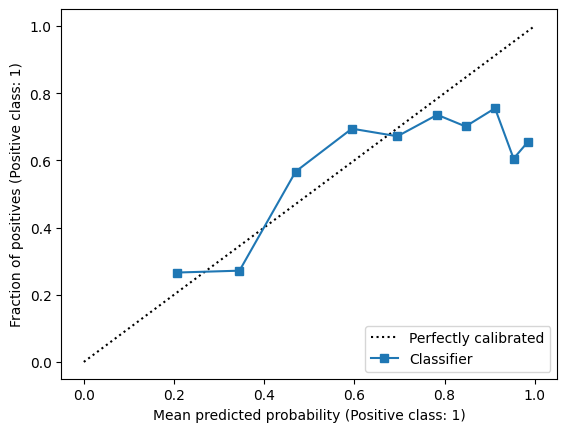

In [67]:
disp = CalibrationDisplay.from_predictions(dfm['label'], dfm['confidence'], n_bins=10, strategy='quantile')

In [68]:
disp.__dict__

{'prob_true': array([0.26601492, 0.27157001, 0.56666667, 0.6942068 , 0.67159763,
        0.73550551, 0.70081086, 0.75496426, 0.60519088, 0.65462389]),
 'prob_pred': array([0.20646195, 0.3452023 , 0.46988114, 0.5944406 , 0.69544752,
        0.78377481, 0.8466623 , 0.91191382, 0.95310807, 0.98470968]),
 'y_prob': 0        0.507732
 1        0.422249
 2        0.541178
 3        0.836901
 4        0.718375
            ...   
 74174    0.721933
 74175    0.600705
 74176    0.424765
 74177    0.699503
 74178    0.606913
 Name: confidence, Length: 74179, dtype: float64,
 'estimator_name': 'Classifier',
 'pos_label': 1,
 'line_': <matplotlib.lines.Line2D at 0x2cde7ba0cd0>,
 'ax_': <Axes: xlabel='Mean predicted probability (Positive class: 1)', ylabel='Fraction of positives (Positive class: 1)'>,
 'figure_': <Figure size 640x480 with 1 Axes>}

In [69]:
dfm['row_cnt'] = 1

## When you look at the calibration by label, it's very inconsistent. Some labels have horrible performance, some have great performance, and it's not connected very well to the confidence score.

## The model doesn't perform great outside of the training sample it was fit on

In [70]:
by_label = dfm.groupby('label_pred').agg({'row_cnt': 'sum', 'confidence': 'mean', 'label': 'mean'})
by_label['difference'] = by_label['label'] - by_label['confidence']
by_label = by_label.rename(columns={'confidence':'mean_confidence_score','label':'proportion_correct'})
by_label.loc[by_label.row_cnt>200].sort_values(by=['difference'])

,row_cnt,mean_confidence_score,proportion_correct,difference
label_pred,,,,
Income Statement - Revenue - Other - Operating - Intercompany Revenue,279,0.895606,0.032258,-0.863348
Income Statement - Revenue - Other - Operating - Other Operating Revenue,6904,0.754427,0.170626,-0.583802
Income Statement - Revenue Deduction - Bad Debt,410,0.804025,0.387805,-0.416220
Income Statement - Revenue Deduction - Charity Care,246,0.830563,0.463415,-0.367149
Income Statement - Revenue - Patient - Gross - Revenue - Outpatient,928,0.801019,0.453664,-0.347355
Income Statement - Revenue - Other - Nonoperating Items - Nonoperating income (loss),2190,0.363166,0.036073,-0.327093
Income Statement - Expenses - Operating - Other Expenses - General and Admin,327,0.514460,0.192661,-0.321799
Income Statement - Expenses - Operating - Benefits - Travel and Education,411,0.526238,0.226277,-0.299961
Balance Sheet - Liabilities - Current - Accrued Expenses,299,0.795951,0.508361,-0.287590


In [71]:
by_label.loc[by_label.row_cnt>50].sort_values(by=['difference']).to_csv('C:/Users/hwallace/glaccount/by_label.csv')

## Similar story by org. The model does poor on many orgs, and it does great on others. The model clearly needs a refit or rebuild for better performance.

In [72]:
by_label = dfm.groupby('orgpin').agg({'row_cnt': 'sum', 'confidence': 'mean', 'label': 'mean'})
by_label['difference'] = by_label['label'] - by_label['confidence']
by_label = by_label.rename(columns={'confidence':'mean_confidence_score','label':'proportion_correct'})
by_label.loc[by_label.row_cnt>50].sort_values(by=['difference'])

,row_cnt,mean_confidence_score,proportion_correct,difference
orgpin,,,,
3105,3216,0.796558,0.005908,-0.790650
2734,4993,0.873153,0.235530,-0.637624
1166,273,0.660034,0.029304,-0.630730
3179,66,0.659889,0.151515,-0.508374
3336,1960,0.731790,0.431122,-0.300668
2980,125,0.484460,0.192000,-0.292460
2993,243,0.800238,0.510288,-0.289950
3396,513,0.643546,0.387914,-0.255632
1259,2085,0.700254,0.471463,-0.228791


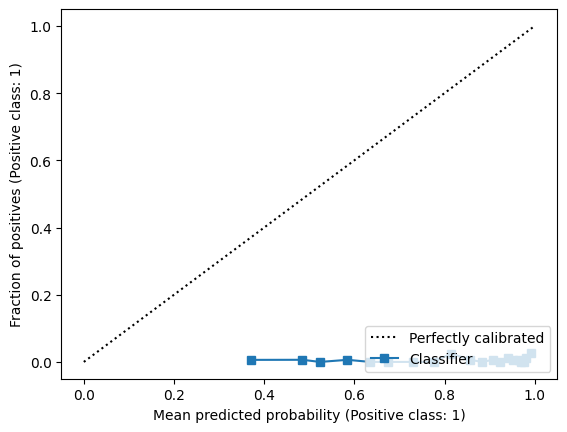

In [73]:
client3105 = dfm[dfm.orgpin=='3105']
disp = CalibrationDisplay.from_predictions(client3105['label'], client3105['confidence'], n_bins=20, strategy='quantile')

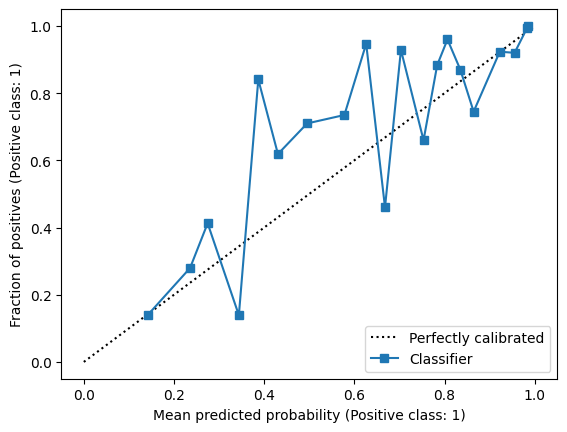

In [74]:
client1152 = dfm[dfm.orgpin=='1152']
disp = CalibrationDisplay.from_predictions(client1152['label'], client1152['confidence'], n_bins=20, strategy='quantile')

<Axes: xlabel='confidence', ylabel='Count'>

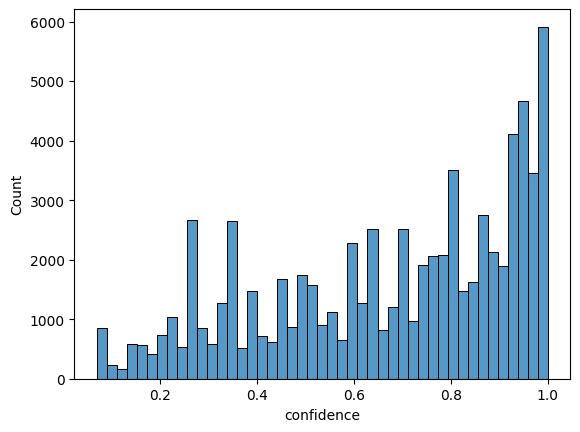

In [75]:
sns.histplot(dfm['confidence'])